<a href="https://colab.research.google.com/github/AstrakhantsevaAA/confidence_estimation_resnet/blob/master/ood_detection_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/AstrakhantsevaAA/confidence_estimation_resnet.git

In [7]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable
from confidence_estimation_resnet.model import resnet
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
process = ['baseline',  'confidence', 'confidence_scaling']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
np.random.seed(0)
torch.cuda.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = False
path = 'confidence_estimation_resnet/checkpoint'
filename = [
            path + '/checkpoint_CIFAR_resnet_0.0.pth', 
            path + '/checkpoint_CIFAR_resnet_0.3.pth'
            ]

model = 'resnet'
validation = False


cuda:0


In [9]:
###########################
### Set up data loaders ###
###########################


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

# # tinyImageNet_crop and LSUN_crop are 36x36, so crop to 32x32
crop_transform = transforms.Compose([transforms.CenterCrop(size=(32, 32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])


num_classes = 10
ind_dataset = datasets.CIFAR10(root='data/',
                                   train=False,
                                   transform=transform,
                                   download=True)


# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet
data_path = 'IMagenet/tiny-imagenet-200/val/'
ood_dataset = datasets.ImageFolder(root=data_path, transform=crop_transform)


ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset,
                                         batch_size=100,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset,
                                         batch_size=100,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)
if validation:
    # Limit dataset to first 1000 samples for validation and fine-tuning
    # Based on validation procedure from https://arxiv.org/abs/1706.02690
    ood_loader.dataset.imgs = ood_loader.dataset.imgs[:1000]
    ood_loader.dataset.__len__ = 1000
else:
    ood_loader.dataset.imgs = ood_loader.dataset.imgs[1000:]
    ood_loader.dataset.__len__ = len(ood_loader.dataset.imgs)

Extracting data/cifar-10-python.tar.gz to data/
Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.


In [11]:
len(ood_loader.dataset.imgs)

9000

In [14]:
##############################
### Load pre-trained model ###
##############################

cnn = resnet.resnet18(num_classes=num_classes)

# model_dict = cnn.state_dict()

pretrained_dict = torch.load(filename[0])
cnn.load_state_dict(pretrained_dict['net'])
cnn = cnn.to(device)
if device == 'cuda':
    cnn = torch.nn.DataParallel(cnn)

cnn.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
##############################################
### Evaluate out-of-distribution detection ###
##############################################

def evaluate(data_loader, mode):
    out = []
    xent = nn.CrossEntropyLoss()
    for data in data_loader:
        if type(data) == list:
            images, labels = data
        else:
            images = data

        images = Variable(images, requires_grad=True).cuda()
        images.retain_grad()

        if mode == 'confidence':
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'confidence_scaling':
            epsilon = args.epsilon

            cnn.zero_grad()
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence).view(-1)
            loss = torch.mean(-torch.log(confidence))
            loss.backward()

            images = images - args.epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'baseline':
            # https://arxiv.org/abs/1610.02136
            pred, _ = cnn(images)
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            pred = pred.cpu().numpy()
            out.append(pred)

    out = np.concatenate(out)
    return out

In [0]:
def tpr95(ind_confidences, ood_confidences):
    #calculate the falsepositive error when tpr is 95%
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / 100000

    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            fpr += error2
            total += 1

    fprBase = fpr / total

    return fprBase


def detection(ind_confidences, ood_confidences, n_iter=100000, return_data=False):
    # calculate the minimum detection error
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / n_iter

    best_error = 1.0
    best_delta = None
    all_thresholds = []
    all_errors = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        detection_error = (tpr + error2) / 2.0

        if return_data:
            all_thresholds.append(delta)
            all_errors.append(detection_error)

        if detection_error < best_error:
            best_error = np.minimum(best_error, detection_error)
            best_delta = delta

    if return_data:
        return best_error, best_delta, all_errors, all_thresholds
    else:
        return best_error, best_delta

In [18]:
ind_scores = evaluate(ind_loader, process[0])
ind_labels = np.ones(ind_scores.shape[0])

ood_scores = evaluate(ood_loader, process[0])
ood_labels = np.zeros(ood_scores.shape[0])

labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([ind_scores, ood_scores])

fpr_at_95_tpr = tpr95(ind_scores, ood_scores)
detection_error, best_delta = detection(ind_scores, ood_scores)
auroc = metrics.roc_auc_score(labels, scores)
aupr_in = metrics.average_precision_score(labels, scores)
aupr_out = metrics.average_precision_score(-1 * labels + 1, 1 - scores)

print("")
print("Method: " + process[0])
print("TPR95 (lower is better): ", fpr_at_95_tpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)


Method: baseline
TPR95 (lower is better):  0.7770115384615369
Detection error (lower is better):  0.2766
Best threshold: 0.9458679706360992
AUROC (higher is better):  0.7886931349999999
AUPR_IN (higher is better):  0.8121456323397817
AUPR_OUT (higher is better):  0.7546181719713818


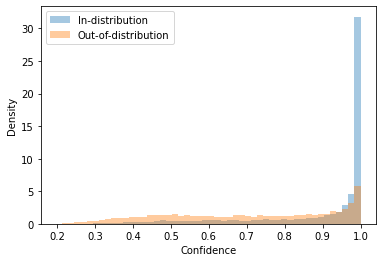

<Figure size 432x288 with 0 Axes>

In [20]:
ranges = (np.min(scores), np.max(scores))
plt.figure()
sns.distplot(ind_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
sns.distplot(ood_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.savefig('confidence_hist_baseline.png')